In [37]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [35]:
# Load the provided files
data_dict_path = "Leads Data Dictionary.xlsx"
leads_data_path = "Leads.csv"

# Read the data dictionary and leads dataset
data_dictionary = pd.read_excel(data_dict_path)
leads_data = pd.read_csv(leads_data_path)

# Display the first few rows of the data dictionary and leads dataset for review
data_dictionary_info = data_dictionary.head()
leads_data_info = leads_data.head()

# Check for missing values and basic statistics in the leads dataset
missing_values = leads_data.isnull().sum()
data_summary = leads_data.describe(include='all').T

# Output the summaries for analysis
data_dictionary_info, leads_data_info, missing_values, data_summary


(   Unnamed: 0   Unnamed: 1                                         Unnamed: 2
 0         NaN          NaN                                                NaN
 1         NaN    Variables                                        Description
 2         NaN  Prospect ID  A unique ID with which the customer is identif...
 3         NaN  Lead Number      A lead number assigned to each lead procured.
 4         NaN  Lead Origin  The origin identifier with which the customer ...,
                             Prospect ID  Lead Number              Lead Origin  \
 0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
 1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
 2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
 3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
 4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   
 
       Lead Source Do Not Email

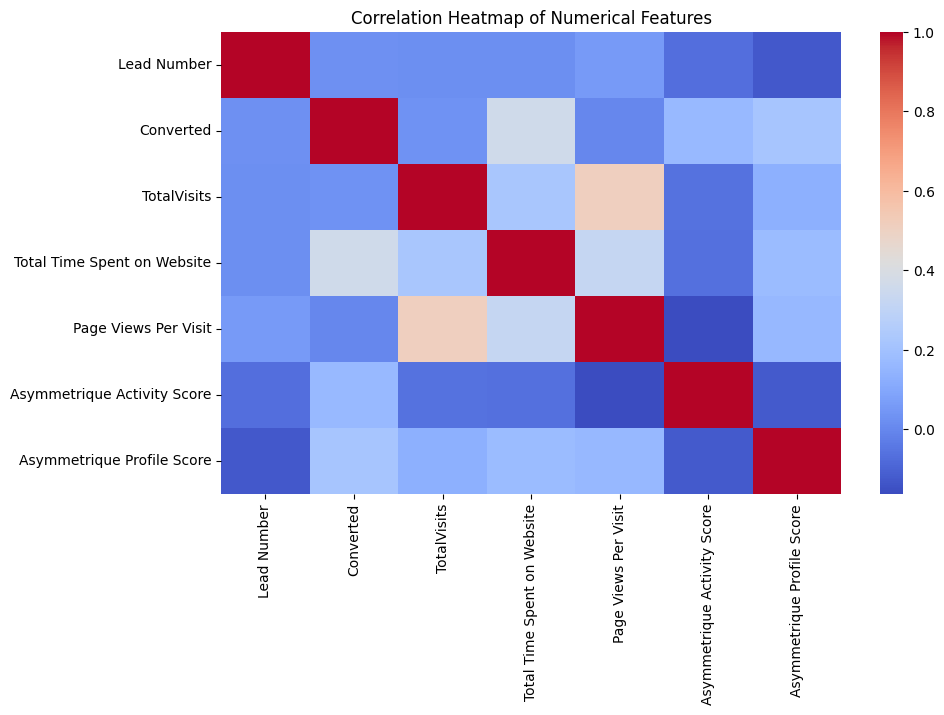

In [39]:
# Correlation heatmap (numerical features only)
numerical_data = leads_data.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numerical_data.corr(), annot=False, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

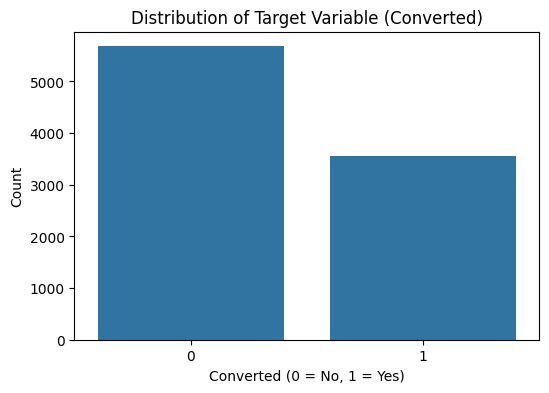

In [40]:
# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Converted', data=leads_data)
plt.title("Distribution of Target Variable (Converted)")
plt.xlabel("Converted (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

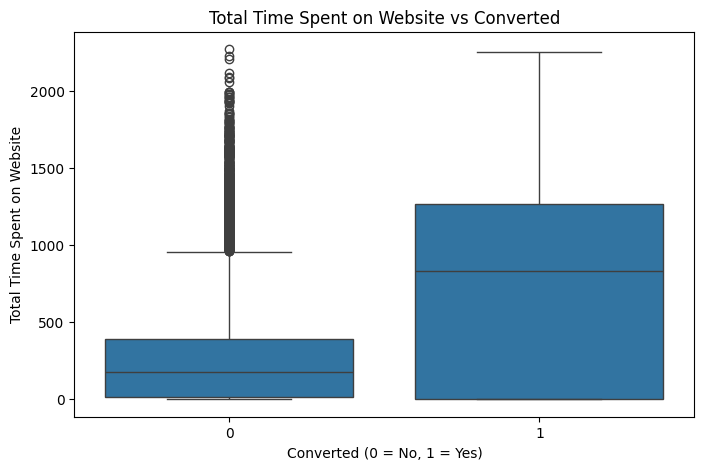

In [43]:
# Boxplot for a key numerical variable vs target
plt.figure(figsize=(8, 5))
sns.boxplot(x='Converted', y='Total Time Spent on Website', data=leads_data)
plt.title("Total Time Spent on Website vs Converted")
plt.xlabel("Converted (0 = No, 1 = Yes)")
plt.ylabel("Total Time Spent on Website")
plt.show()

C:\Users\Snowwolf\AppData\Local\Temp\ipykernel_19352\3696465508.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Lead Source', y='Converted', data=leads_data, ci=None, order=leads_data['Lead Source'].value_counts().index[:10])


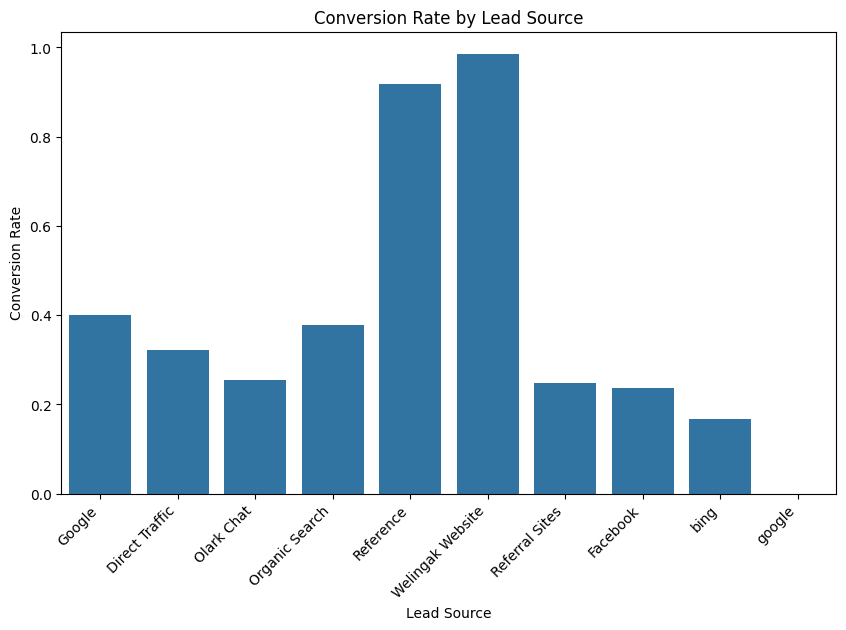

In [42]:
# Barplot for a key categorical variable vs target
plt.figure(figsize=(10, 6))
sns.barplot(x='Lead Source', y='Converted', data=leads_data, ci=None, order=leads_data['Lead Source'].value_counts().index[:10])
plt.xticks(rotation=45, ha='right')
plt.title("Conversion Rate by Lead Source")
plt.xlabel("Lead Source")
plt.ylabel("Conversion Rate")
plt.show()

In [3]:
#Drop irrelevant or redundant columns
columns_to_drop = [
    'Prospect ID', 'Lead Number',  # Unique identifiers
    'Magazine', 'Receive More Updates About Our Courses',  # Constant value columns
    'Update me on Supply Chain Content', 'Get updates on DM Content',  # Constant values
    'I agree to pay the amount through cheque'  # Irrelevant for prediction
]

leads_data = leads_data.drop(columns=columns_to_drop, axis=1)

In [4]:
# Handle missing values
# Replace 'Select' in categorical columns with NaN
leads_data.replace('Select', pd.NA, inplace=True)

# Impute missing categorical variables with mode
categorical_cols = leads_data.select_dtypes(include='object').columns
for col in categorical_cols:
    leads_data[col].fillna(leads_data[col].mode()[0], inplace=True)

# Impute missing numerical variables with median
numerical_cols = leads_data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    leads_data[col].fillna(leads_data[col].median(), inplace=True)

C:\Users\Snowwolf\AppData\Local\Temp\ipykernel_19352\3027762471.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  leads_data[col].fillna(leads_data[col].mode()[0], inplace=True)
C:\Users\Snowwolf\AppData\Local\Temp\ipykernel_19352\3027762471.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [5]:
# Address outliers by capping at 95th percentile
for col in ['TotalVisits', 'Page Views Per Visit']:
    leads_data[col] = leads_data[col].clip(upper=leads_data[col].quantile(0.95))

In [6]:
# One-hot encode categorical variables
leads_data = pd.get_dummies(leads_data, drop_first=True)

In [7]:
# Correlation analysis for feature selection
correlation_with_target = leads_data.corr()['Converted'].sort_values(ascending=False)

# Identify features with a correlation above a threshold (e.g., 0.05)
selected_features = correlation_with_target[abs(correlation_with_target) > 0.05].index.tolist()

# Exclude the target variable itself
selected_features = [feature for feature in selected_features if feature != 'Converted']

# Prepare the final dataset for modeling
X = leads_data[selected_features]
y = leads_data['Converted']

# Output the selected features and their correlation with the target variable
selected_features_summary = correlation_with_target[selected_features]
selected_features_summary

Total Time Spent on Website                             0.362483
Last Notable Activity_SMS Sent                          0.351845
Tags_Will revert after reading the email                0.339760
Last Activity_SMS Sent                                  0.325600
Lead Origin_Lead Add Form                               0.321702
What is your current occupation_Working Professional    0.313837
Lead Source_Reference                                   0.270830
Tags_Closed by Horizzon                                 0.251229
Lead Quality_Low in Relevance                           0.230770
Tags_Lost to EINS                                       0.168937
Asymmetrique Profile Score                              0.157824
Lead Source_Welingak Website                            0.154153
Asymmetrique Activity Score                             0.120331
Asymmetrique Activity Index_02.Medium                   0.118409
Specialization_Marketing Management                     0.065853
Lead Profile_Lateral Stud

In [9]:
# Prepare the final dataset with selected features
X = leads_data[selected_features]
y = leads_data['Converted']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [10]:
# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

C:\Users\Snowwolf\miniconda3\envs\statistics\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [11]:
# Predict on the test set
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1] #default -> 0.5

In [12]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

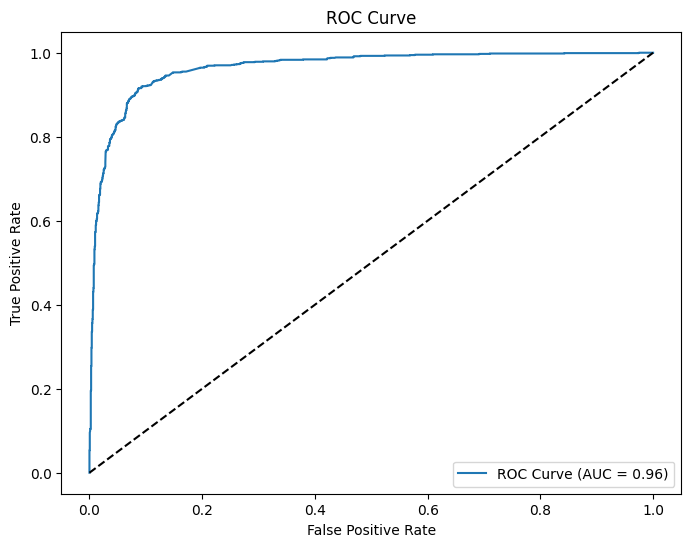

{'Accuracy': 0.9083694083694084,
 'Precision': np.float64(0.8921001926782274),
 'Recall': np.float64(0.8670411985018727),
 'F1 Score': np.float64(0.879392212725546),
 'ROC AUC': np.float64(0.9644719518735383),
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.92      0.93      0.93      1704\n           1       0.89      0.87      0.88      1068\n\n    accuracy                           0.91      2772\n   macro avg       0.91      0.90      0.90      2772\nweighted avg       0.91      0.91      0.91      2772\n'}

In [13]:
# Generate a classification report
classification_rep = classification_report(y_test, y_pred)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Display evaluation metrics and classification report
{
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
    "Classification Report": classification_rep
}

In [15]:
# Assign lead scores based on predicted probabilities
lead_scores = (y_pred_proba * 100).round(2)

# Add lead scores to the test dataset for reference
X_test_with_scores = X_test.copy()
X_test_with_scores['Lead Score'] = lead_scores
X_test_with_scores['Converted'] = y_test.values

In [23]:
# Perform feature importance analysis
# Logistic regression coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Display the lead scores and feature importance

In [24]:
coefficients.head(10)

,Feature,Coefficient
9,Tags_Lost to EINS,6.381391
7,Tags_Closed by Horizzon,5.396103
2,Tags_Will revert after reading the email,2.666118
4,Lead Origin_Lead Add Form,2.043807
11,Lead Source_Welingak Website,1.824333
1,Last Notable Activity_SMS Sent,1.408312
16,Tags_Busy,1.220531
3,Last Activity_SMS Sent,0.949238
5,What is your current occupation_Working Profes...,0.819383
13,Asymmetrique Activity Index_02.Medium,0.729897


In [25]:
X_test_with_scores[["Lead Score", "Converted"]].head(10)

,Lead Score,Converted
8305,32.46,0
1591,78.45,1
8604,2.48,0
1333,6.99,0
4260,0.11,0
2357,98.41,1
1900,74.82,1
9077,1.35,0
6302,97.16,1
8158,91.00,1


In [26]:
#Question 1

In [27]:
# Extract the top 3 features with the highest coefficients
top_features = coefficients.sort_values(by='Coefficient', ascending=False).head(3)

# Display the top 3 features
print("Top 3 Variables Contributing to Lead Conversion:")
print(top_features)

Top 3 Variables Contributing to Lead Conversion:
                                    Feature  Coefficient
9                         Tags_Lost to EINS     6.381391
7                   Tags_Closed by Horizzon     5.396103
2  Tags_Will revert after reading the email     2.666118


In [28]:
#Question 2

In [29]:
# Filter out the categorical/dummy variables based on the feature names
# Assuming categorical variables in this dataset are identified by having multiple levels in their names
categorical_features = coefficients[coefficients['Feature'].str.contains('_')]

# Extract the top 3 categorical/dummy variables with the highest positive coefficients
top_categorical_features = categorical_features.sort_values(by='Coefficient', ascending=False).head(3)

# Display the top 3 categorical/dummy variables
print("Top 3 Categorical/Dummy Variables to Focus On:")
print(top_categorical_features)


Top 3 Categorical/Dummy Variables to Focus On:
                                    Feature  Coefficient
9                         Tags_Lost to EINS     6.381391
7                   Tags_Closed by Horizzon     5.396103
2  Tags_Will revert after reading the email     2.666118


In [30]:
#Question3

In [31]:
#Question 4